# Saliency on Serialized Detections

This notebook demonstrates the use of the `xaitk-saliency` package to compute saliency maps for serialized detections formatted in the COCO style.

[COCO style annotations](https://cocodataset.org/#format-data) contain all relevant information in a single json file.
This includes images, categories, and bounding boxes labeled for category and image.
Predicted bounding boxes should also include a score or individual class probabilities.

`xaitk-saliency` provides implementations of the `GenerateObjectDetectorBlackboxSaliency` interface for generating visual saliency maps for reference predictions made by object detection models.
It also provides utility functions to easily format serialized COCO detections for use with these implementations.
We use these two in combination in this example to create a complete workflow from serialized detections to saliency maps.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/SerializedDetectionSaliency.ipynb)

## Set up environment

We need to install the "tools" extra for `xaitk-saliency` which includes `kwcoco`, the package used for working with COCO style annotations, and the "centernet" extra for `smqtk-detection` which includes the dependencies for the PyTorch-based `CenterNetVisdrone` class.

**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys  # noqa

!{sys.executable} -m pip install -qU pip
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency[tools]
print("Installing smqtk-detection...")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
# Remove opencv-python, which required libGL, which we don't require here, and replace with opencv-python-headless
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing xaitk-saliency...
Installing smqtk-detection...
Installing headless OpenCV...
Done!


## Instantiate Saliency Generator

We will use the `DRISEStack` class to generate our saliency maps.
This uses the `RISEGrid` and `DRISEScoring` image perturbation and scoring algorithms, respectively, to generate saliency based on observations made on randomly occluded versions of our reference image.

The number of perturbation masks is set to `20`.
Using more masks will increase the quality of the resulting saliency maps, but we limit that number here to reduce our computational time.

Using a fill other than black when occluding your images can improve saliency results.
We will pass the RGB channel values of a gray fill to use here.

In [2]:
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

sal_generator = DRISEStack(
    n=20,  # number of masks
    s=8,  # occlusion grid size
    p1=0.5,  # probability of not occluding cell
    fill=[95, 96, 93],  # gray fill RGB values
    threads=8,  # seed for replicable results
    seed=0,
)

## Instantiate Detector

The `GenerateObjectDetectorBlackboxSaliency` interface requires a `smqtk_detection.DetectImageObjects` implementation as input to use as the object detector.
We will use the `CenterNetVisdrone` class from `smqtk-detection` for ours.
This is a wrapper around a PyTorch implementation of [CenterNet](https://arxiv.org/pdf/1904.07850.pdf) pretrained on the [VisDrone2019 dataset](https://arxiv.org/pdf/1804.07437v2.pdf).

Ideally, the number of proposals made by our detector should be greater than the number of detections we are computing saliency for.
This is to ensure that there is a similar proposal for the `D-RISE` algorithm to match to each of our reference detections.
We will set the `max_dets` parameter for `CenterNetVisdrone` to `500` for this reason.

Note that the `use_cuda` parameter is currently set to `False`, but can be set to `True` if a GPU is available.

In [3]:
import logging
import os
import urllib

from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone

logging.basicConfig(level=logging.INFO)

data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# download weights
model_file = os.path.join(data_dir, "centernet-resnet50.pth")
if not os.path.isfile(model_file):
    urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download", model_file)

detector = CenterNetVisdrone(
    arch="resnet50",
    model_file=f"{data_dir}/centernet-resnet50.pth",
    max_dets=500,
    use_cuda=False,
    batch_size=3,
    num_workers=1,
)

INFO:smqtk_detection.impls.detect_image_objects.centernet:=> loading pretrained model https://download.pytorch.org/models/resnet50-19c8e357.pth
INFO:smqtk_detection.impls.detect_image_objects.centernet:loaded data/centernet-resnet50.pth, epoch 100


## Download Detections and Image

Our file contains 10 predictions made by the CenterNet model for a single image taken from the test split of VisDrone2019.

In [4]:
# Pre-computed detections, COCO-format serialization, top-10 highest confidence detections.
dets_path = os.path.join(data_dir, "coco-dets.json")
if not os.path.isfile(dets_path):
    _ = urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/62325a9d4acac99f426f220b/download", dets_path)

img_path = os.path.join(data_dir, "drone.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/62325a9e4acac99f426f2213/download", img_path)

## Load Detections and Visualize

We create a `kwcoco.CocoDataset` object from our serialized detections.
The `kwcoco` package provides a set of robust set of load and query tools for COCO style annotations.
This allows us to easily work with the the detections in the file.

Note that these detections are a subset of all the predictions made by the CenterNet model for this image.
The number of detections is restricted here to reduce computational overhead.

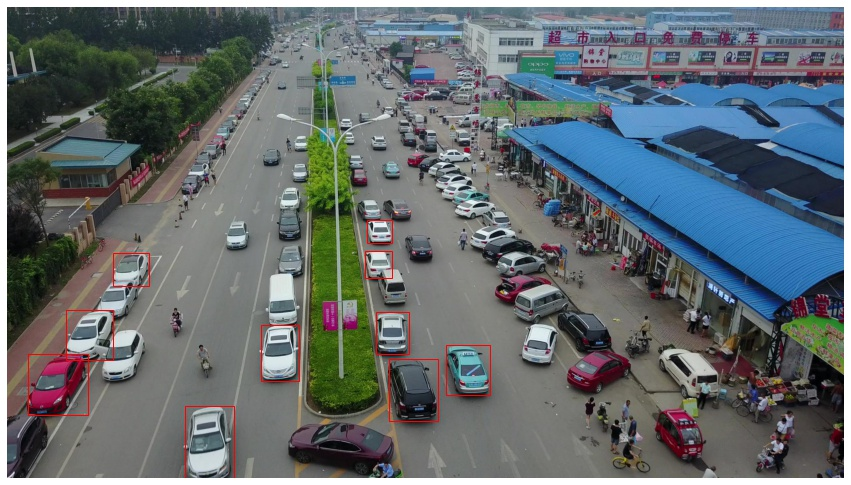

In [5]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

import kwcoco
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image

dets_dset = kwcoco.CocoDataset(dets_path)

# Visualize detections
img = np.asarray(Image.open(img_path))

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img)

for det in dets_dset.anns.values():
    bbox = det["bbox"]
    plt.gca().add_patch(Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none"))

## Prepare Inputs

The `GenerateObjectDetectorBlackboxSaliency` interface requires separate bounding boxes and scores inputs for the reference detections that we want to compute saliency for.
The `parse_coco_dset()` utility function from `xaitk_saliency.utils.gen_coco_sal` help us easily create these.
The function yields a (`ref_img`, `bboxes`, `scores`) tuple for each image in the input `kwcoco.CocoDataset` object that has corresponding annotations.


Our dataset contains the "ignored_regions" and "others" categories which we will remove to match the output of our detector, which does not output these categories.

In [6]:
from xaitk_saliency.utils.coco import parse_coco_dset

# delete "ignored_regions" category
del dets_dset.cats[0]
# delete "others" category
del dets_dset.cats[11]

ref_img, bboxes, scores = next(iter(parse_coco_dset(dets_dset)))

print(f"bboxes: {bboxes.shape}")
print(f"scores: {scores.shape}")

bboxes: (10, 4)
scores: (10, 10)


## Generate Saliency Maps

Now we will call our saliency generator object with our formatted inputs to compute the visual saliency maps for our predictions.

In [7]:
import time

start = time.time()

sal_maps = sal_generator(ref_img, bboxes, scores, detector)

end = time.time()
print("Elapsed time: %0.2fs" % (end - start))
print(f"Saliency maps generated: {len(sal_maps)}")

INFO:smqtk_detection.impls.detect_image_objects.centernet:[1/7]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[2/7]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[3/7]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[4/7]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[5/7]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[6/7]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[7/7]


Elapsed time: 38.84s
Saliency maps generated: 10


## Visualize Saliency

The saliency maps can be displayed over the reference image to show the salient regions for each detection.
Here we do this for a single detection.
The value of the `detection_id` variable can be changed to visualize a different detection's saliency.

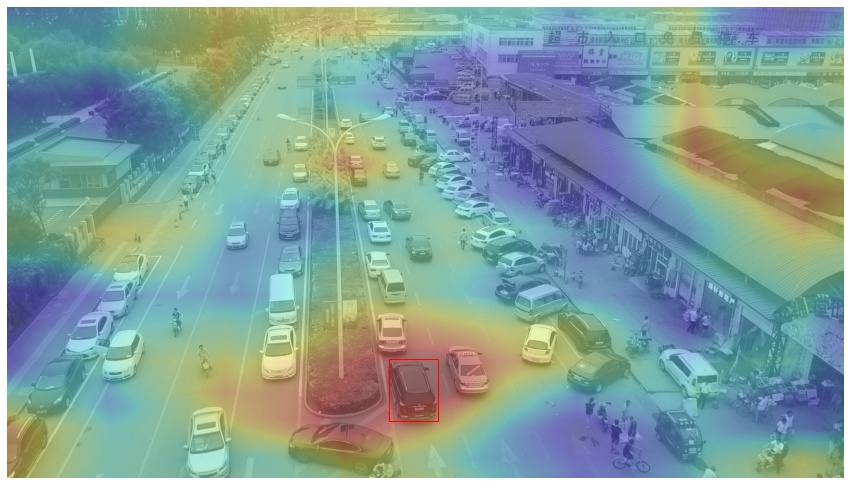

In [8]:
# "Select" Detection ID to visualize saliency for
# - Change to different value (0-9) to visualize different detections
detection_id = 0  # 1, 5, 7


# Visualize Detction and Saliency
def plot_saliency_map(det_id, sal_maps_results=sal_maps) -> None:
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    gray_img = np.asarray(Image.fromarray(img).convert("L"))
    plt.imshow(gray_img, alpha=0.7, cmap="gray")

    bbox = dets_dset.anns[detection_id]["bbox"]
    plt.gca().add_patch(Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none"))
    plt.imshow(sal_maps_results[det_id], cmap="jet", alpha=0.3)


plot_saliency_map(detection_id)

## Exercise
The above saliency heatmap is clearly very coarse.
This is due to the parameterization of our explanation algorithms.

The granularity of detail in our saliency heatmap is correlated to the quantity of observations that we make of the black-box algorithm.
Thus, with more input variations, as well as more granularity in the changes between variations, we can aggregate a finer grained understanding of what is and is not important to the black-box in its decision making.

Try executing the following cell, which instantiates an alternate `DRISEStack` instance with a more detailed set of parameters.
This new parameter set increases the quantity of perturbations of the base image 10-fold (`n`, 20 -> 200), as well as increases the resolution of the grid in which image variations are introduced 3-fold (`s`, 8 -> 24).

**NOTE:** The following require more memory resources than the previous parameterization to accommodate the larger matrix multiplication operations performed. Use of a GPU is recommended for accelerated processing.